<a href="https://colab.research.google.com/github/esciencecenter-digital-skills/2021-11-17-surf-bootcamp-parallel-python/blob/main/Parallel_Programming_in_Python_Mini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Parallel programming
This tutorial is a selection from the larger [workshop on Parallel Programming in Python](https://carpentries-incubator.github.io/lesson-parallel-python/) that we teach at the [Netherlands eScience Center](https://www.esciencecenter.nl/digital-skills/).

Parallel programming is the utilization of multiple compute units, wether it be cores on a CPU or multiple nodes in a cluster, to perform some task faster than it would otherwise be on a single worker.

We can visualize a computation by creating a diagram where we see how each operation depends on previous ones. We call this directed acyclic graph (DAG) the **dependency diagram**, and we'll see a lot of them in this tutorial. Suppose we add up the numbers 1, 2, 3, 4, then one way to compute this in sequence is:

![Serial computation](https://carpentries-incubator.github.io/lesson-parallel-python/fig/serial.png)

Since the order of addition doesn't matter, we can also do this in parallel:

![Parallel computation](https://carpentries-incubator.github.io/lesson-parallel-python/fig/parallel.png)

In this instance we could divide the work among two workers and be (almost) twice as fast. Here what we mean by *worker* is either a node on a cluster or a core on a CPU. We need to make the distinction between workers in a **shared-memory** or **distributed-memory** architectures. In the case of distributed memory, like on a HPC cluster where you use multiple nodes, you need to worry about communicating intermediate results between nodes. This will give overhead that you need to worry about, both in terms of programming and performance.

![Memory architectures](https://carpentries-incubator.github.io/lesson-parallel-python/fig/memory-architecture.svg)

In this tutorial we will show how you can do this in Python using Dask and Numba. We will focus on creating parallel programs that perform well on shared-memory architectures, for example a multi-core laptop or a node on your local HPC cluster.


Let's see how many cores we have available:

In [ ]:
import psutil
N_physical_cores = psutil.cpu_count(logical=False)
N_logical_cores = psutil.cpu_count(logical=True)
print(f"The number of physical/logical cores is {N_physical_cores}/{N_logical_cores}")

The number of physical/logical cores is 1/2


For most of you, the number of logical cores will be twice the number of physical cores. This is due to a CPU feature known as [hyper-threading](https://en.wikipedia.org/wiki/Hyper-threading). This feature will give speed-ups for some tasks but usually not so much for heavy numeric work. It is important to keep that in mind when choosing how many parallel threads to start.

# Computing $\pi$

In order to recognize the advantages of parallelization we need an algorithm that is easy to parallelize, but still complex enough to take a few seconds of CPU time. To not scare away the interested reader, we need this algorithm to be understandable and, if possible, also interesting. We chose a classical algorithm for demonstrating parallel programming: estimating the value of number π.

The algorithm we present is one of the classical examples of the power of Monte-Carlo methods. This is an umbrella term for several algorithms that use random numbers to approximate exact results. We chose this algorithm because of its simplicity and straightforward geometrical interpretation.

We can compute the value of π using a random number generator. We count the points falling inside the blue circle M compared to the green square N. Then π is approximated by the ratio 4M/N.

![Computing Pi](https://carpentries-incubator.github.io/lesson-parallel-python/fig/calc_pi_3_wide.svg)

## Exercise 1
Use only standard Python and the function `random.uniform`. The function should have the following interface:

```python
import random
def calc_pi(N):
    """Computes the value of pi using N random samples."""
    ...
    for i in range(N):
        # take a sample
        ...
    return ...
```

Can you explain why this implementation is so slow?

## A Vectorized version in NumPy

We cannot talk about parallel programming without first making our implementation a bit faster. After all, what use is it to parallelise our code when we can gain much more in performance by other means?

The secret of optimizing Python code and later also when it comes to parallelisation, is to take things away from Python. Even as a scripting language Python was never designed for efficiency, rather it is a glue language, telling how to use and combine more efficient lower level routines, a bit like a puppet player.

You may already be familiar with optimizing a Python program by rewriting it in a **vectorized** form using NumPy.

In [ ]:
import numpy as np

def calc_pi_numpy(N):
    # Simulate impact coordinates
    pts = np.random.uniform(-1, 1, (2, N))
    # Count number of impacts inside the circle
    M = np.count_nonzero((pts**2).sum(axis=0) < 1)
    return 4 * M / N

In [ ]:
calc_pi_numpy(10**8)

3.14175096

The downside of this method is that it can take a lot of memory! Try running this function with a larger input size while running a system monitor (if you run this code locally). One easy way of both parallelising this function and solving the memory issue, is to use Dask Arrays. This interface mirrors most of what you can do with ordinary NumPy, and parallelises for free! **Try to guess at how to translate our `calc_pi_numpy` function to a Dask enabled function.**

In [ ]:
from dask import array as da

def calc_pi_dask(N):
  ...

Now if we try to run this code something strange happens:

In [ ]:
calc_pi_dask(10**8)

dask.array<truediv, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

We need to tell Dask explicitely that we'd like to compute our result.

In [ ]:
calc_pi_dask(10**8).compute()

3.14176328

We can actually do much better than that. Let's try Numba. Numba is a **just-in-time** compiler for a subset of Python. You can have it compile parts of your Python code to machine code. For simple operations it is as easy as pasting the `@numba.jit` decorator in front of your function definition. **Use it on your first pure Python implementation of `calc_pi`.**

In [ ]:
import numba
import random

@numba.jit(nopython=True, nogil=True)
def calc_pi_numba(N):
  ...

In [ ]:
calc_pi_numba(10**9)

3.14167996

Those of you that read documentation could find out that the `numba.jit` function accepts an argument `parallel=True`, but we're not going to use that since it is much more instructive to parallelise this function with Dask's `delayed` interface.

# Delayed evaluation
The underlying concept that makes Dask tick is **delayed evaluation**. By working on delayed values (also known as promises) Dask builds a dependency diagram of your computation. When the graph is evaluated (when we call the `compute()` method), Dask automatically parallelises independent tasks.

In [1]:
from dask import delayed

In [2]:
@delayed
def add(a, b):
  return a + b

It can often be helpful to annotate your code, so that you remember what values are actually promises.

In [3]:
x_p = add(1, 2)

In [4]:
type(x_p)

dask.delayed.Delayed

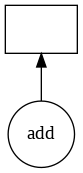

In [5]:
x_p.visualize()

If we use the promise as an argument to further delayed function calls, we keep getting more promises and the dependency diagram is extended.

In [6]:
y_p = add(x_p, 3)
z_p = add(y_p, x_p)

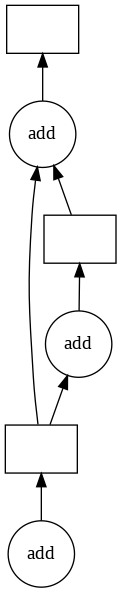

In [7]:
z_p.visualize()

## Variadic arguments
In Python you can define functions that take arbitrary number of arguments:

In [8]:
def add(*args):
  return sum(args)

add(1, 2, 3, 4)

10

You can use tuple-unpacking to pass a sequence of arguments:

In [9]:
numbers = [1, 2, 3, 4]
add(*numbers)

10

## Exercise 2
Design a delayed function that computes the mean of its arguments:

```python
>>> mean(1, 2, 3, 4).compute()
2.5
```

Compute a sequence of $\pi$ approximations and compute its mean. Make sure that the entire computation is contained in a single promise:

```python
approximations = [delayed(calc_pi_numba)(10**8) for _ in range(10)]
```

Pass this list into your `mean` function such that you get back a promise of a single number. Visualise the dependency diagram.